In [58]:
from typing import Callable

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

In [59]:
# df = pd.read_csv("../ml/prices_train.csv")
df = pd.read_csv("train.csv")

Lat + long = address

In [ ]:
geolocator = Nominatim(user_agent="my_geopy_app")

def convert(row):
    for _ in range(100):
        try:
            addr = geolocator.reverse((row["X5 latitude"], row["X6 longitude"]), language="en").raw["address"]
            return addr.get("country", None), addr.get("city", None), addr.get("village", None), addr.get("suburb", None), addr.get("neighbourhood", None), addr.get("road", None), addr.get("house_number", None)
        except GeocoderTimedOut:
            pass
    raise GeocoderTimedOut()

df["X7 country"], df["X8 city"], df["X9 village"], df["X10 suburb"], df["X11 neighbourhood"], df["X12 road"], df["X13 house_number"] = zip(*df.apply(convert, axis=1))

In [60]:
countryEncoder = LabelEncoder()
df["X7 country"] = countryEncoder.fit_transform(df["X7 country"])

cityEncoder = LabelEncoder()
df["X8 city"] = cityEncoder.fit_transform(df["X8 city"])

villageEncoder = LabelEncoder()
df["X9 village"] = villageEncoder.fit_transform(df["X9 village"])

suburbEncoder = LabelEncoder()
df["X10 suburb"] = suburbEncoder.fit_transform(df["X10 suburb"])

neighbourhoodEncoder = LabelEncoder()
df["X11 neighbourhood"] = neighbourhoodEncoder.fit_transform(df["X11 neighbourhood"])

roadEncoder = LabelEncoder()
df["X12 road"] = roadEncoder.fit_transform(df["X12 road"])

house_numberEncoder = LabelEncoder()
df["X13 house_number"] = house_numberEncoder.fit_transform(df["X13 house_number"])

<Axes: >

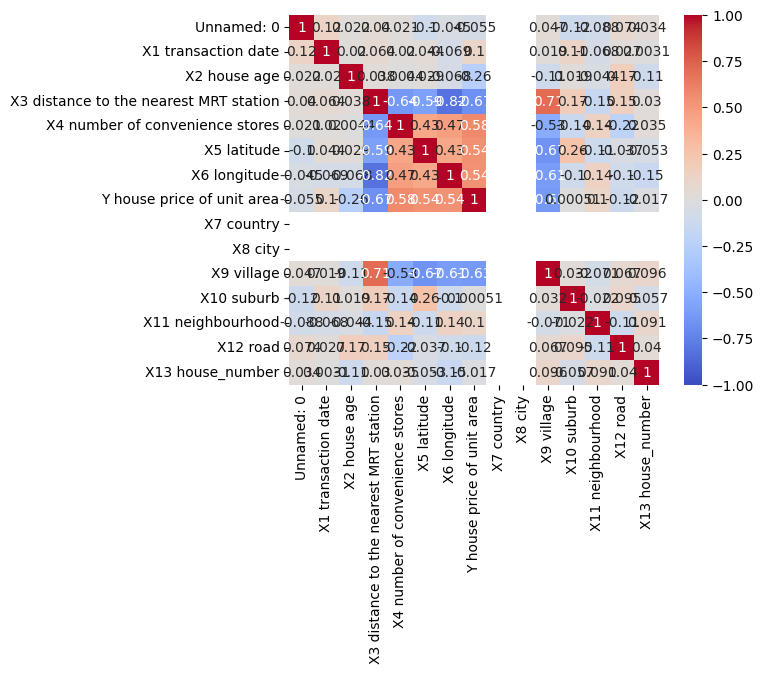

In [61]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True, square=True)

In [62]:
df.drop(["X8 city", "X7 country"], axis=1, inplace=True)

In [63]:
df.isna().sum()

Unnamed: 0                                 0
X1 transaction date                        0
X2 house age                               8
X3 distance to the nearest MRT station     7
X4 number of convenience stores           14
X5 latitude                                0
X6 longitude                               0
Y house price of unit area                 0
X9 village                                 0
X10 suburb                                 0
X11 neighbourhood                          0
X12 road                                   0
X13 house_number                           0
dtype: int64

In [64]:
px.scatter_map(df, lat="X5 latitude", lon="X6 longitude", color="Y house price of unit area")

In [65]:
def evalModel(X_train: pd.DataFrame, X_test: pd.DataFrame, Y_train: pd.Series, Y_test: pd.Series) -> tuple[float, float]:
    model = LinearRegression()
    model.fit(X_train, Y_train)

    fn = "Y = " + " + ".join(f"({c:.3f} * X{i})" for i, c in enumerate(model.coef_))

    Y_pred = model.predict(X_test)
    return float(r2_score(Y_test, Y_pred)), float(mean_squared_error(Y_test, Y_pred))

In [66]:
def evalParam[T](title: str, param: list[T], paramName: str, fn: Callable[[T], tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]]):
    r2 = []
    mse = []

    for p in param:
        r, m = evalModel(*fn(p))
        r2.append(r)
        mse.append(m)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(title)

    ax1.plot(param, mse)
    ax1.set(xlabel=paramName, ylabel="MSE")
    ax1.label_outer()
    ax1.grid()

    ax2.plot(param, r2)
    ax2.set(xlabel=paramName, ylabel="R2")
    ax1.label_outer()
    ax2.grid()

    plt.show()

    best = min(range(len(mse)), key=lambda i: abs(mse[i]))
    return mse[best], param[best]

In [67]:
df

,Unnamed: 0,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,X9 village,X10 suburb,X11 neighbourhood,X12 road,X13 house_number
0,0,2013.083,34.0,157.6052,7.0,24.96628,121.54196,39.1,0,0,54,10,16
1,1,2013.500,13.3,561.9845,5.0,24.98746,121.54391,54.8,0,0,44,26,102
2,2,2012.917,13.7,1236.5640,1.0,24.97694,121.55391,30.6,0,0,6,26,102
3,3,2013.500,8.5,104.8101,5.0,24.96674,121.54067,55.5,0,0,43,8,65
4,4,2013.500,13.2,1164.8380,NaN,24.99156,121.53406,34.3,2,0,12,62,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,326,2013.417,38.5,216.8329,7.0,24.98086,121.54162,41.0,0,0,13,15,80
327,327,2013.417,9.7,421.4790,5.0,24.98246,121.54477,49.3,0,0,7,116,98
328,328,2012.750,0.0,208.3905,6.0,24.95618,121.53844,44.0,4,0,49,18,92
329,329,2013.167,16.2,2288.0110,3.0,24.95885,121.51359,24.4,4,0,19,100,82


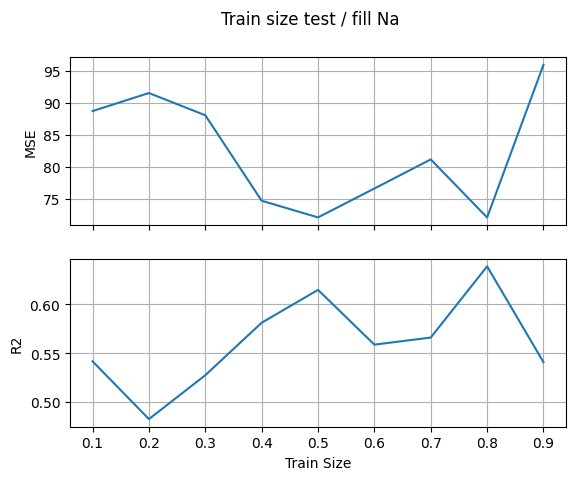

(72.09013553914113, 0.8)

In [68]:
df0 = df.copy()

df0["X2 house age"] = df0["X2 house age"].fillna(df0["X2 house age"].mean())
df0["X3 distance to the nearest MRT station"] = df0["X3 distance to the nearest MRT station"].fillna(df0["X3 distance to the nearest MRT station"].mean())
df0["X4 number of convenience stores"] = df0["X4 number of convenience stores"].fillna(df0["X4 number of convenience stores"].mean())

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude", "X9 village", "X10 suburb", "X11 neighbourhood", "X12 road", "X13 house_number"]]
Y = df0["Y house price of unit area"]

def testTrainSize(tSize: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=tSize, random_state=42)
    return X_train, X_test, Y_train, Y_test

evalParam("Train size test / fill Na", [.1, .2, .3, .4, .5, .6, .7, .8, .9], "Train Size", testTrainSize)

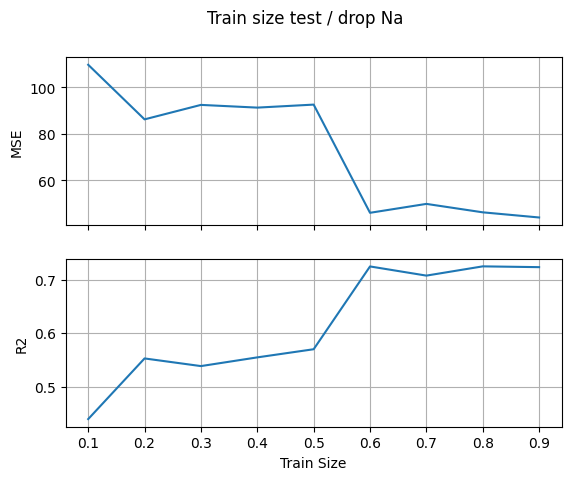

(44.08267187255834, 0.9)

In [69]:
df0 = df.copy()

df0 = df0.dropna()

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude", "X9 village", "X10 suburb", "X11 neighbourhood", "X12 road", "X13 house_number"]]
Y = df0["Y house price of unit area"]

def testTrainSize(tSize: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=tSize, random_state=42)
    return X_train, X_test, Y_train, Y_test

evalParam("Train size test / drop Na", [.1, .2, .3, .4, .5, .6, .7, .8, .9], "Train Size", testTrainSize)

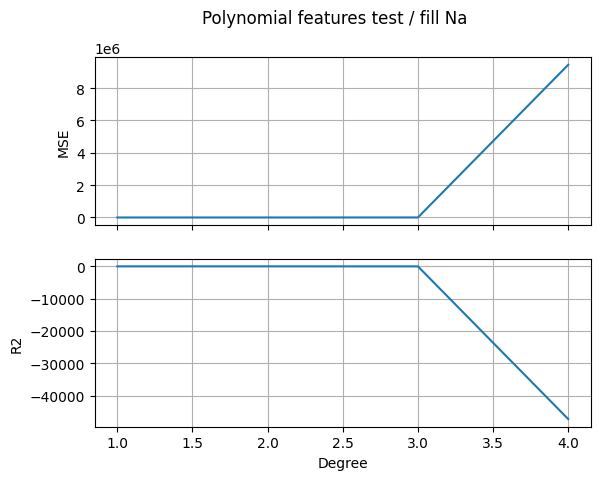

(62.46731917083321, 2)

In [70]:
df0 = df.copy()

df0["X2 house age"] = df0["X2 house age"].fillna(df0["X2 house age"].mean())
df0["X3 distance to the nearest MRT station"] = df0["X3 distance to the nearest MRT station"].fillna(df0["X3 distance to the nearest MRT station"].mean())
df0["X4 number of convenience stores"] = df0["X4 number of convenience stores"].fillna(df0["X4 number of convenience stores"].mean())

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude", "X9 village", "X10 suburb", "X11 neighbourhood", "X12 road", "X13 house_number"]]
Y = df0["Y house price of unit area"]

def testPolyDegree(degree: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    return X_train_poly, X_test_poly, Y_train, Y_test

evalParam("Polynomial features test / fill Na", list(range(1, 5)), "Degree", testPolyDegree)

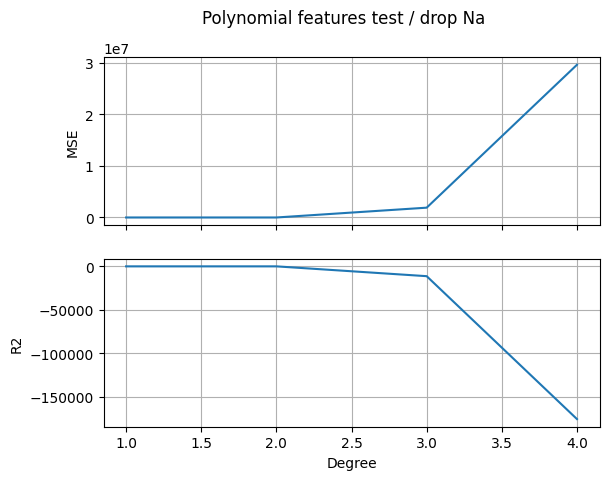

(46.29959303137117, 1)

In [71]:
df0 = df.copy()

df0 = df0.dropna()
X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude", "X9 village", "X10 suburb", "X11 neighbourhood", "X12 road", "X13 house_number"]]
Y = df0["Y house price of unit area"]

def testPolyDegree(degree: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    return X_train_poly, X_test_poly, Y_train, Y_test

evalParam("Polynomial features test / drop Na", list(range(1, 5)), "Degree", testPolyDegree)

In [72]:
df0 = df.copy()

df0 = df0.dropna()

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X5 latitude", "X6 longitude", "X9 village", "X10 suburb", "X11 neighbourhood", "X12 road", "X13 house_number"]]
Y = df0["Y house price of unit area"]
print(evalModel(*train_test_split(X, Y, train_size=.8, random_state=42)))

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X9 village", "X10 suburb"]]
Y = df0["Y house price of unit area"]
print(evalModel(*train_test_split(X, Y, train_size=.8, random_state=42)))

(0.7248713567543826, 46.29959303137106)
(0.7446077423564305, 42.97828627644604)


Best result

In [73]:
df0 = df.copy()

df0 = df0.dropna()

X = df0[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X9 village", "X10 suburb"]]
Y = df0["Y house price of unit area"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

fn = "Y = " + " + ".join(f"({c:.3f} * X{i})" for i, c in enumerate(model.coef_, 1))

Y_pred = model.predict(X_test)
mse = float(mean_squared_error(Y_test, Y_pred))

print(f"MSE({mse})")
print(fn)

MSE(42.97828627644604)
Y = (7.379 * X1) + (-0.295 * X2) + (-0.003 * X3) + (0.852 * X4) + (-2.568 * X5) + (9.979 * X6)


In [74]:
df = pd.read_csv("../ml/prices_test.csv")

df["X7 country"], df["X8 city"], df["X9 village"], df["X10 suburb"], df["X11 neighbourhood"], df["X12 road"], df["X13 house_number"] = zip(*df.apply(convert, axis=1))

In [81]:
df.isna().sum()

Unnamed: 0                                 0
X1 transaction date                        0
X2 house age                               0
X3 distance to the nearest MRT station     0
X4 number of convenience stores            0
X5 latitude                                0
X6 longitude                               0
X7 country                                 0
X8 city                                    0
X9 village                                32
X10 suburb                                 0
X11 neighbourhood                          0
X12 road                                   3
X13 house_number                          14
dtype: int64

In [82]:
df["X3 distance to the nearest MRT station"] = df["X3 distance to the nearest MRT station"].fillna(df["X3 distance to the nearest MRT station"].mean())
df["X4 number of convenience stores"] = df["X4 number of convenience stores"].fillna(df["X4 number of convenience stores"].mean())
df["X9 village"] = df["X9 village"].fillna(df["X9 village"].mode())
df["X12 road"] = df["X12 road"].fillna(df["X12 road"].mode())
df["X13 house_number"] = df["X13 house_number"].fillna(df["X13 house_number"].mode())

In [84]:
df["X9 village"] = villageEncoder.transform(df["X9 village"])
df["X10 suburb"] = suburbEncoder.transform(df["X10 suburb"])

In [85]:
X_test = df[["X1 transaction date", "X2 house age", "X3 distance to the nearest MRT station", "X4 number of convenience stores", "X9 village", "X10 suburb"]]
df["Y house price of unit area"] = model.predict(X_test)

In [97]:
df["Y house price of unit area"].to_frame().to_csv("result.csv")